# 互评作业2: 频繁模式与关联规则挖掘

3120245622 王雨卉 数据挖掘作业2

程序所在代码仓库地址：[Github](https://github.com/ZhangYHe/BIT-DataMining-2024)

## 1. 要求

### 1.1 数据说明

数据集为互评作业1中 Parquet 格式文件，包含用户的购物历史记录。每条记录的 purchase_history 字段是一个 JSON 对象，包含以下信息：

· 商品ID（item_id）

· 商品数量（item_count）

· 商品价格（price）

· 商品类别（categories）：包括以下几大类：

  - 1 电子产品：智能手机、笔记本电脑、平板电脑、智能手表、耳机、音响、相机、摄像机、游戏机

  - 2 服装：上衣、裤子、裙子、内衣、鞋子、帽子、手套、围巾、外套

  - 3 食品：零食、饮料、调味品、米面、水产、肉类、蛋奶、水果、蔬菜

  - 4 家居：家具、床上用品、厨具、卫浴用品

  - 5 办公：文具、办公用品

  - 6 运动户外：健身器材、户外装备

  - 7 玩具：玩具、模型、益智玩具

  - 8 母婴：婴儿用品、儿童课外读物

  - 9 汽车用品：车载电子、汽车装饰

· 支付状态（payment_status）

· 支付方式（payment_method）

· 购买日期（purchase_date）

更正说明：忽略purchase_history中的catetories字段

### 1.2. 任务目标

#### 1. 商品类别关联规则挖掘
- 分析用户在同一订单中购买的不同商品类别之间的关联关系  
- 找出支持度（support）≥ 0.02、置信度（confidence）≥ 0.5的频繁项集和关联规则  
- 特别关注电子产品与其他类别之间的关联关系  

#### 2. 支付方式与商品类别的关联分析  
- 挖掘不同支付方式与商品类别之间的关联规则  
- 分析高价值商品（价格 > 5000）的首选支付方式  
- 找出支持度 ≥ 0.01、置信度 ≥ 0.6的规则  

#### 3. 时间序列模式挖掘  
- 分析用户购物行为的季节性模式（按季度、月份或星期）  
- 识别特定商品类别在不同时间段的购买频率变化  
- 探索"先购买A类别，后购买B类别"的时序模式  

#### 4. 退款模式分析  
- 挖掘与"已退款"或"部分退款"状态相关的商品类别组合  
- 分析导致退款的可能商品组合模式  
- 找出支持度 ≥ 0.005、置信度 ≥ 0.4的规则  

### 1.3. 技术要求

- 处理 Parquet 格式的数据文件
- 实现 Apriori 或 FP-Growth 算法进行频繁项集挖掘
- 计算并评估挖掘出的关联规则的支持度、置信度和提升度、或其他度量
- 对挖掘结果进行可视化展示
- 撰写分析报告，解释发现的模式及其业务价值

### 1.4. 提交要求

- 完整的源代码（任选编程语言），提供代码仓库地址，同时上传压缩格式的仓库导出文件
- 数据处理和分析的详细说明文档
- 挖掘出的频繁模式和关联规则列表
- 分析报告



## 2. 数据处理

[10G数据集](/home/wangyuhui/dataset/10G_dataset)

[30G数据集](/home/wangyuhui/dataset/30G_dataset)

In [45]:
import duckdb
import json
import pandas as pd

# 创建内存数据库
con = duckdb.connect(':memory:')

# 自动发现Parquet文件（支持通配符）
parquet_files = "/home/wangyuhui/dataset/30G_dataset/part-*.parquet"

In [46]:
# 创建分类层级映射关系
category_hierarchy = {
    '电子产品': ['智能手机', '笔记本电脑', '平板电脑', '智能手表', '耳机', '音响', '相机', '摄像机', '游戏机'],
    '服装': ['上衣', '裤子', '裙子', '内衣', '鞋子', '帽子', '手套', '围巾', '外套'],
    '食品': ['零食', '饮料', '调味品', '米面', '水产', '肉类', '蛋奶', '水果', '蔬菜'],
    '家居': ['家具', '床上用品', '厨具', '卫浴用品'],
    '办公': ['文具', '办公用品'],
    '运动户外': ['健身器材', '户外装备'],
    '玩具': ['玩具', '模型', '益智玩具'],
    '母婴': ['婴儿用品', '儿童课外读物'],
    '汽车用品': ['车载电子', '汽车装饰']
}

# 转换为二维表结构
mapping_data = []
for category_name, subcategories in category_hierarchy.items():
    for subcategory in subcategories:
        mapping_data.append({'subcategory': subcategory, 'category_name': category_name})

# 创建分类映射表
category_hierarchy_df = pd.DataFrame(mapping_data)
con.register('category_hierarchy', category_hierarchy_df)

In [47]:
# 加载映射表
with open('/home/wangyuhui/dataset/product_catalog.json') as f:
    mapping_data = json.load(f)

# 转换为 DataFrame
category_map = pd.DataFrame(mapping_data['products'])
con.register('category_map', category_map)

### 数据预处理


In [ ]:
# 创建临时表并加载数据
raw_data = con.execute(f"""
CREATE TABLE temp_json AS
SELECT id,purchase_history
FROM read_parquet('{parquet_files}');

ALTER TABLE temp_json
ADD COLUMN json_data JSON;

UPDATE temp_json
SET json_data = json(purchase_history);
""")


In [49]:
# 解析 JSON 数据并创建 purchase_history_table 表
con.execute(f"""
CREATE TABLE purchase_history_table AS
SELECT 
    id AS order_id,
    json_extract(json_data, '$.avg_price')::INTEGER AS avg_price,
    json_extract(json_data, '$.categories')::VARCHAR AS categories,
    json_extract(json_data, '$.payment_method')::VARCHAR AS payment_method,
    json_extract(json_data, '$.payment_status')::VARCHAR AS payment_status,
    json_extract(json_data, '$.purchase_date')::DATE AS purchase_date,
    json_extract(json_data, '$.items[*].id')::INT[] AS items
FROM temp_json
where json_array_length(json_extract(json_data, '$.items')) > 1;
""")

In [ ]:
# 创建 analysis_table 表(展开items 列表)
con.execute(f"""
CREATE TABLE analysis_table AS                           
SELECT 
    p.order_id,
    p.item_id,
    c.category,  -- 从 category_map 获取分类
    h.category_name,  -- 使用分类层级表中的主分类名称
    c.price,     -- 从 category_map 获取价格
    p.payment_method,
    p.payment_status,
    p.purchase_date
FROM (
    -- 先展开 items 列表
    SELECT 
        order_id,
        UNNEST(items) AS item_id,
        categories,
        payment_method,
        payment_status,
        purchase_date
    FROM purchase_history_table
) AS p
LEFT JOIN category_map AS c  -- 根据 item_id 关联
    ON p.item_id = c.id    -- 确保字段名和类型一致
LEFT JOIN category_hierarchy AS h  -- 新增分类层级关联
    ON c.category = h.subcategory; 
""").fetchdf()



Parsed item data:
   order_id  item_id category category_name    price payment_method  \
0         0     8852     智能手机          电子产品  1339.09         "微信支付"   
1         0     2079       耳机          电子产品   518.16         "微信支付"   
2         0     5043       内衣            服装   109.01         "微信支付"   
3         1     1584      摄像机          电子产品  7169.43         "微信支付"   
4         1     8242       上衣            服装   629.46         "微信支付"   

  payment_status purchase_date  
0         "部分退款"    2021-09-30  
1         "部分退款"    2021-09-30  
2         "部分退款"    2021-09-30  
3          "已退款"    2025-02-18  
4          "已退款"    2025-02-18  


In [ ]:
# 创建 analysis_count_table 表(商品数量统计)
con.execute(f"""
CREATE TABLE analysis_count_table AS
SELECT 
    order_id,
    item_id,
    -- 统计相同 order_id + item_id 的数量
    COUNT(*) AS item_count,
    -- 其他字段按需聚合（假设同一分组下这些字段值相同）
    MAX(category) AS category,      -- 取第一个分类（若不同则需处理）
    MAX(category_name) AS category_name,
    MAX(payment_method) AS payment_method,
    MAX(payment_status) AS payment_status,
    MAX(purchase_date) AS purchase_date
FROM analysis_table                -- 使用前一步 JOIN 后的表
GROUP BY order_id, item_id          -- 按订单和商品分组
ORDER BY order_id, item_count DESC; -- 按订单和数量排序
""").fetchdf()


Parsed item data:
   order_id  item_id  item_count category category_name payment_method  \
0      7677     7589           2       围巾            服装          "支付宝"   
1      7945     3814           2       裙子            服装          "支付宝"   
2      9957     7473           2      调味品            食品          "云闪付"   

  payment_status purchase_date  
0          "已退款"    2022-01-10  
1          "已支付"    2020-07-25  
2          "已退款"    2023-07-19  


In [ ]:
# 分析数据事务表
con.execute(f"""
CREATE OR REPLACE TABLE transactions AS
SELECT 
    order_id,
    ARRAY_AGG(category_name) AS categories,  -- 保留重复类别（默认不去重）
    -- 其他字段需明确聚合（假设同一订单下这些字段值唯一）
    MAX(payment_method) AS payment_method,  -- 支付方式（唯一）
    MAX(payment_status) AS payment_status,  -- 支付状态（唯一）
    MAX(purchase_date) AS purchase_date     -- 购买日期（唯一）
FROM analysis_table
GROUP BY order_id;  -- 按订单分组，其他字段用 MAX 聚合
""").fetchdf()

data = con.execute(f"""
select * from transactions;
""").fetchdf()
print("Parsed item data:")
print(data.head())

Parsed item data:
   order_id                categories payment_method payment_status  \
0        35                [汽车用品, 玩具]          "云闪付"         "部分退款"   
1        37            [食品, 食品, 汽车用品]         "微信支付"          "已支付"   
2        54      [食品, 服装, 服装, 玩具, 母婴]           "现金"          "已支付"   
3        62                [服装, 电子产品]          "信用卡"          "已支付"   
4        64  [食品, 电子产品, 运动户外, 食品, 食品]          "储蓄卡"         "部分退款"   

  purchase_date  
0    2022-11-21  
1    2021-06-28  
2    2021-04-19  
3    2023-10-05  
4    2020-07-27  


### 2.1  同一订单中的不同商品类别之间的关系



In [53]:
# 分析频繁项集
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori
# 转换为 频繁集 需要的事务列表格式
transaction_list = data["categories"].tolist()

print("修正后的事务列表示例（前5条）：")
print(transaction_list[:5])

# 将事务列表编码为布尔矩阵
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)


# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets_apriori = apriori(
    df_trans,
    min_support=0.02, 
    max_len=3,
    use_colnames=True
)

# 挖掘频繁项集
frequent_itemsets_fpgrowth = fpgrowth(
    df_trans, 
    min_support=0.02,  # 支持度阈值
    max_len=3,
    use_colnames=True   # 使用类别名称而非列索引
)

print("频繁项集（Apriori）:\n", frequent_itemsets_apriori)
print("频繁项集（FP-Growth）:\n", frequent_itemsets_fpgrowth)


修正后的事务列表示例（前5条）：
[array(['汽车用品', '玩具'], dtype=object), array(['食品', '食品', '汽车用品'], dtype=object), array(['食品', '服装', '服装', '玩具', '母婴'], dtype=object), array(['服装', '电子产品'], dtype=object), array(['食品', '电子产品', '运动户外', '食品', '食品'], dtype=object)]
频繁项集（Apriori）:
      support          itemsets
0   0.165828              (办公)
1   0.290891              (家居)
2   0.557247              (服装)
3   0.150604              (母婴)
4   0.152743            (汽车用品)
..       ...               ...
61  0.035732    (食品, 运动户外, 服装)
62  0.033971    (电子产品, 母婴, 食品)
63  0.030322  (电子产品, 汽车用品, 食品)
64  0.046678    (玩具, 电子产品, 食品)
65  0.033468  (电子产品, 食品, 运动户外)

[66 rows x 2 columns]
频繁项集（FP-Growth）:
      support        itemsets
0   0.224082            (玩具)
1   0.152743          (汽车用品)
2   0.553221            (食品)
3   0.557247            (服装)
4   0.150604            (母婴)
..       ...             ...
61  0.079643        (办公, 食品)
62  0.030825        (办公, 玩具)
63  0.034977  (办公, 电子产品, 服装)
64  0.035355    (办公, 食品, 服装)
65  0.0

In [54]:
# 分析用户在同一订单中购买的不同商品类别之间的关联关系
# 计算关联规则
rules_apriori = association_rules(
    frequent_itemsets_apriori, 
    metric="confidence", 
    min_threshold=0.5, # 置信度阈值
)

# 计算关联规则
rules_fpgrowth = association_rules(
    frequent_itemsets_fpgrowth, 
    metric="confidence", 
    min_threshold=0.5,  # 置信度阈值
)

print("关联规则（apriori）:\n", rules_apriori)
print("关联规则（FP-Growth）:\n", rules_fpgrowth)

关联规则（apriori）:
   antecedents consequents  antecedent support  consequent support   support  \
0        (办公)        (服装)            0.165828            0.557247  0.082914   
1      (电子产品)        (服装)            0.553473            0.557247  0.281958   
2        (服装)      (电子产品)            0.557247            0.553473  0.281958   
3        (食品)        (服装)            0.553221            0.557247  0.276799   
4      (电子产品)        (食品)            0.553473            0.553221  0.278686   
5        (食品)      (电子产品)            0.553221            0.553473  0.278686   
6      (运动户外)        (食品)            0.160040            0.553221  0.080020   

   confidence      lift  representativity  leverage  conviction  \
0    0.500000  0.897268               1.0 -0.009493    0.885506   
1    0.509434  0.914198               1.0 -0.026463    0.902535   
2    0.505983  0.914198               1.0 -0.026463    0.903871   
3    0.500341  0.897880               1.0 -0.031482    0.886110   
4    0.503524  0

/home/wangyuhui/.conda/envs/etl/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


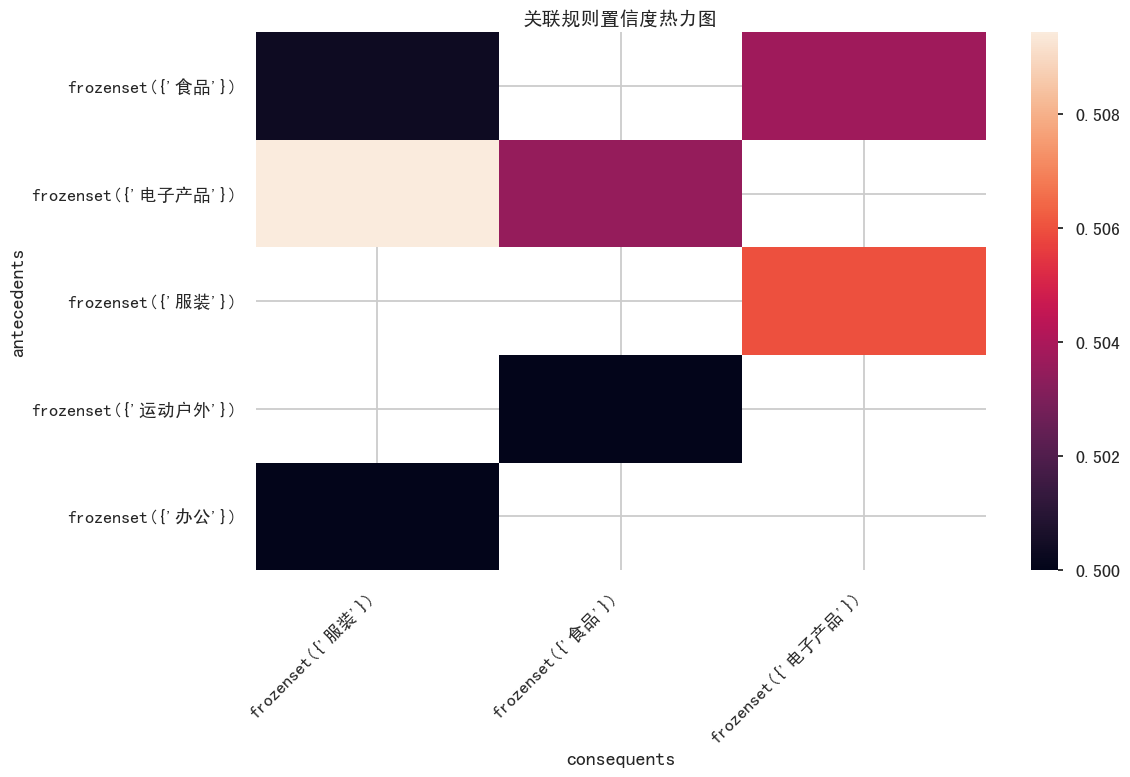

In [55]:
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
# 设置字体路径    
font_path = '/home/wangyuhui/.conda/envs/etl/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/Ubuntu_18.04_SimHei 2.ttf'
fm.fontManager.addfont(font_path)

# 设置可视化风格
plt.style.use('seaborn-v0_8-talk')
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
print(matplotlib.matplotlib_fname())

# 过滤有效规则
valid_rules = rules_fpgrowth.dropna(subset=['confidence'])

# 绘制规则热力图
plt.figure(figsize=(12, 8))  # 设置画布尺寸（可选）
sns.heatmap(
    valid_rules.pivot(
        index='antecedents',
        columns='consequents',
        values='confidence'
    )
)

# 优化布局并保存图片
plt.title("关联规则置信度热力图", fontsize=14)  # 添加标题（可选）
plt.xticks(rotation=45, ha='right')  # 旋转X轴标签
plt.tight_layout()  # 防止标签重叠
plt.savefig("images/association_rules_heatmap.png", dpi=300, bbox_inches="tight")  # 保存高清图片
plt.show()  # 显示图表


In [56]:
# 选择属于电子产品的规则
# apriori 规则
electronics_rules_apriori = rules_apriori[
    rules_apriori['antecedents'].apply(lambda x: any(item in '电子产品' for item in x)) |
    rules_apriori['consequents'].apply(lambda x: any(item in '电子产品' for item in x))
]

# fpgrowth 规则
electronics_rules_fpgrowth = rules_fpgrowth[
    rules_fpgrowth['antecedents'].apply(lambda x: any(item in '电子产品' for item in x)) |
    rules_fpgrowth['consequents'].apply(lambda x: any(item in '电子产品' for item in x))
]


print("电子产品关联规则（apriori）:\n", electronics_rules_apriori[["antecedents", "consequents", "support", "confidence", "lift"]])
print("电子产品关联规则（FP-Growth）:\n", electronics_rules_fpgrowth[["antecedents", "consequents", "support", "confidence", "lift"]])

电子产品关联规则（apriori）:
   antecedents consequents   support  confidence      lift
1      (电子产品)        (服装)  0.281958    0.509434  0.914198
2        (服装)      (电子产品)  0.281958    0.505983  0.914198
4      (电子产品)        (食品)  0.278686    0.503524  0.910167
5        (食品)      (电子产品)  0.278686    0.503753  0.910167
电子产品关联规则（FP-Growth）:
   antecedents consequents   support  confidence      lift
1      (电子产品)        (食品)  0.278686    0.503524  0.910167
2        (食品)      (电子产品)  0.278686    0.503753  0.910167
3      (电子产品)        (服装)  0.281958    0.509434  0.914198
4        (服装)      (电子产品)  0.281958    0.505983  0.914198


In [57]:
# 保存任务1的关联规则和频繁项集
electronics_rules_apriori.to_csv("/home/wangyuhui/dm_wyh2/csv/task1_apriori_rules.csv", index=False)
electronics_rules_fpgrowth.to_csv("/home/wangyuhui/dm_wyh2/csv/task1_fpgrowth_rules.csv", index=False)
frequent_itemsets_apriori.to_csv("/home/wangyuhui/dm_wyh2/csv/task1_apriori_itemsets.csv", index=False)
frequent_itemsets_fpgrowth.to_csv("/home/wangyuhui/dm_wyh2/csv/task1_fpgrowth_itemsets.csv", index=False)

### 2.2 不同支付方式与商品类别之间的关联规则

- 分析高价值商品（价格 > 5000）的首选支付方式
- 找出支持度 ≥ 0.01、置信度 ≥ 0.6的规则

In [58]:
# 分析频繁项集
transaction_list_2 = []
for _, row in data.iterrows():
    # 提取商品类别列表（假设已正确拆分为列表，如 ['a', 'c']）
    categories = row["categories"].tolist()
    # 清洗支付方式名称（去除双引号）
    payment_method_strip = row['payment_method'].strip('"')
    payment_method = f"PAYMENT_{payment_method_strip}"
    # 合并商品类别与支付方式为单个事务（如 ['a', 'c', 'b']）
    transaction = categories + [payment_method]
    transaction_list_2.append(transaction)


print("修正后的事务列表示例（前5条）：")
print(transaction_list_2[:5])

# 编码并挖掘规则（支持度 ≥ 0.01，置信度 ≥ 0.6）
te = TransactionEncoder()
te_ary = te.fit_transform(transaction_list_2)
df_trans_2 = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets_apriori_2 = apriori(
    df_trans_2,
    min_support=0.01, 
    use_colnames=True
)

# 挖掘频繁项集
frequent_itemsets_fpgrowth_2 = fpgrowth(
    df_trans_2, 
    min_support=0.01,  # 支持度阈值
    use_colnames=True   # 使用类别名称而非列索引
)

print("频繁项集（Apriori）:\n", frequent_itemsets_apriori_2)
print("频繁项集（FP-Growth）:\n", frequent_itemsets_fpgrowth_2)

修正后的事务列表示例（前5条）：
[['汽车用品', '玩具', 'PAYMENT_云闪付'], ['食品', '食品', '汽车用品', 'PAYMENT_微信支付'], ['食品', '服装', '服装', '玩具', '母婴', 'PAYMENT_现金'], ['服装', '电子产品', 'PAYMENT_信用卡'], ['食品', '电子产品', '运动户外', '食品', '食品', 'PAYMENT_储蓄卡']]
频繁项集（Apriori）:
       support              itemsets
0    0.147584         (PAYMENT_云闪付)
1    0.143936         (PAYMENT_信用卡)
2    0.140916         (PAYMENT_储蓄卡)
3    0.149597        (PAYMENT_微信支付)
4    0.132109         (PAYMENT_支付宝)
..        ...                   ...
302  0.023528    (家居, 电子产品, 食品, 服装)
303  0.012456    (电子产品, 母婴, 食品, 服装)
304  0.010946  (电子产品, 汽车用品, 食品, 服装)
305  0.015979    (电子产品, 玩具, 食品, 服装)
306  0.013337  (电子产品, 运动户外, 食品, 服装)

[307 rows x 2 columns]
频繁项集（FP-Growth）:
       support            itemsets
0    0.224082                (玩具)
1    0.152743              (汽车用品)
2    0.147584       (PAYMENT_云闪付)
3    0.553221                (食品)
4    0.149597      (PAYMENT_微信支付)
..        ...                 ...
302  0.033468      (办公, 电子产品, 食品)
303  0.012204  (办公, 电子产

In [59]:
# 分析不同支付方式与商品类别之间的关联规则
# 计算关联规则
rules_apriori_2 = association_rules(
    frequent_itemsets_apriori_2, 
    metric="confidence", 
    min_threshold=0.6, # 置信度阈值
)

# 计算关联规则
rules_fpgrowth_2 = association_rules(
    frequent_itemsets_fpgrowth_2, 
    metric="confidence", 
    min_threshold=0.6,  # 置信度阈值
)

print("关联规则（apriori）:\n", rules_apriori_2[["antecedents", "consequents", "support", "confidence", "lift"]])
print("关联规则（FP-Growth）:\n", rules_fpgrowth_2 [["antecedents", "consequents", "support", "confidence", "lift"]])

PAYMENT_PREFIX = 'PAYMENT_'
payment_category_rules_apriori = rules_apriori_2[
    rules_apriori_2['antecedents'].apply(lambda x: any(item.startswith(PAYMENT_PREFIX) for item in x)) |
    rules_apriori_2['consequents'].apply(lambda item_set: any(item.startswith(PAYMENT_PREFIX) for item in item_set))
]

payment_category_rules_fpgrowth = rules_fpgrowth_2[
    rules_fpgrowth_2['antecedents'].apply(lambda x: any(item.startswith(PAYMENT_PREFIX) for item in x)) |
    rules_fpgrowth_2['consequents'].apply(lambda item_set: any(item.startswith(PAYMENT_PREFIX) for item in item_set))
]

# 展示结果
print(payment_category_rules_apriori[['antecedents', 'consequents', 'support', 'confidence']])
print(payment_category_rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence']])

关联规则（apriori）:
           antecedents consequents   support  confidence      lift
0  (PAYMENT_银联, 汽车用品)        (服装)  0.013085    0.601156  1.078796
关联规则（FP-Growth）:
           antecedents consequents   support  confidence      lift
0  (PAYMENT_银联, 汽车用品)        (服装)  0.013085    0.601156  1.078796
          antecedents consequents   support  confidence
0  (PAYMENT_银联, 汽车用品)        (服装)  0.013085    0.601156
          antecedents consequents   support  confidence
0  (PAYMENT_银联, 汽车用品)        (服装)  0.013085    0.601156


In [60]:
# 分析高价值商品的支付方式 groupby price>5000 category_name
# 分析数据事务表
data_high_price = con.execute(f"""
SELECT 
    order_id,
    ARRAY_AGG(category_name) AS categories,  -- 保留重复类别（默认不去重）
    -- 其他字段需明确聚合（假设同一订单下这些字段值唯一）
    MAX(payment_method) AS payment_method,  -- 支付方式（唯一）
FROM analysis_table
WHERE 
    price > 5000  -- 筛选高价值商品
    AND category_name IS NOT NULL  -- 排除无分类商品
GROUP BY 
    order_id;  -- 按订单分组 
""").fetchdf()


print("Parsed item data:")
print(data_high_price.head())

Parsed item data:
   order_id categories payment_method
0        11     [电子产品]           "现金"
1        83     [电子产品]          "信用卡"
2        91       [家居]          "储蓄卡"
3       182     [电子产品]           "现金"
4       244     [电子产品]          "信用卡"


In [61]:
# 分析频繁项集-高价值商品
transaction_list_2_high_price = []
for _, row in data_high_price.iterrows():
    # 提取商品类别列表（假设已正确拆分为列表，如 ['a', 'c']）
    categories = row["categories"].tolist()
    # 清洗支付方式名称（去除双引号）
    payment_method_strip = row['payment_method'].strip('"')
    payment_method = f"PAYMENT_{payment_method_strip}"
    # 合并商品类别与支付方式为单个事务（如 ['a', 'c', 'b']）
    transaction = categories + [payment_method]
    transaction_list_2_high_price.append(transaction)


print("修正后的事务列表示例（前5条）：")
print(transaction_list_2_high_price[:5])

# 编码并挖掘规则（支持度 ≥ 0.01，置信度 ≥ 0.6）
te = TransactionEncoder()
te_ary = te.fit_transform(transaction_list_2_high_price)
df_trans_2 = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets_apriori_2_high_price = apriori(
    df_trans_2,
    min_support=0.01, 
    use_colnames=True
)

# 挖掘频繁项集
frequent_itemsets_fpgrowth_2_high_price = fpgrowth(
    df_trans_2, 
    min_support=0.01,  # 支持度阈值
    use_colnames=True   # 使用类别名称而非列索引
)

print("频繁项集（Apriori）:\n", frequent_itemsets_apriori_2_high_price)
print("频繁项集（FP-Growth）:\n", frequent_itemsets_fpgrowth_2_high_price)

修正后的事务列表示例（前5条）：
[['电子产品', 'PAYMENT_现金'], ['电子产品', 'PAYMENT_信用卡'], ['家居', 'PAYMENT_储蓄卡'], ['电子产品', 'PAYMENT_现金'], ['电子产品', 'PAYMENT_信用卡']]
频繁项集（Apriori）:
      support              itemsets
0   0.144756         (PAYMENT_云闪付)
1   0.155672         (PAYMENT_信用卡)
2   0.141908         (PAYMENT_储蓄卡)
3   0.145230        (PAYMENT_微信支付)
4   0.124822         (PAYMENT_支付宝)
5   0.141908          (PAYMENT_现金)
6   0.145705          (PAYMENT_银联)
7   0.160418                  (家居)
8   0.872805                (电子产品)
9   0.018035     (家居, PAYMENT_云闪付)
10  0.130517   (电子产品, PAYMENT_云闪付)
11  0.026103     (PAYMENT_信用卡, 家居)
12  0.135263   (PAYMENT_信用卡, 电子产品)
13  0.022781     (家居, PAYMENT_储蓄卡)
14  0.122449   (电子产品, PAYMENT_储蓄卡)
15  0.026103    (家居, PAYMENT_微信支付)
16  0.125771  (电子产品, PAYMENT_微信支付)
17  0.020883     (PAYMENT_支付宝, 家居)
18  0.108685   (PAYMENT_支付宝, 电子产品)
19  0.020408      (家居, PAYMENT_现金)
20  0.125771    (电子产品, PAYMENT_现金)
21  0.026103      (家居, PAYMENT_银联)
22  0.124347    (电子产品, PAYMENT_银联)
23  0

In [62]:
# 分析不同支付方式与商品类别之间的关联规则
# 计算关联规则
rules_apriori_2_high_price = association_rules(
    frequent_itemsets_apriori_2_high_price, 
    metric="confidence", 
    min_threshold=0.6, # 置信度阈值
)

# 计算关联规则
rules_fpgrowth_2_high_price = association_rules(
    frequent_itemsets_fpgrowth_2_high_price, 
    metric="confidence", 
    min_threshold=0.6,  # 置信度阈值
)

print("关联规则（apriori）:\n", rules_apriori_2_high_price[["antecedents", "consequents", "support", "confidence", "lift"]])
print("关联规则（FP-Growth）:\n", rules_fpgrowth_2_high_price [["antecedents", "consequents", "support", "confidence", "lift"]])

PAYMENT_PREFIX = 'PAYMENT_'
payment_category_rules_apriori_high_price = rules_apriori_2_high_price[
    rules_apriori_2_high_price['antecedents'].apply(lambda x: any(item.startswith(PAYMENT_PREFIX) for item in x)) |
    rules_apriori_2_high_price['consequents'].apply(lambda item_set: any(item.startswith(PAYMENT_PREFIX) for item in item_set))
]

payment_category_rules_fpgrowth_high_price = rules_fpgrowth_2_high_price[
    rules_fpgrowth_2_high_price['antecedents'].apply(lambda x: any(item.startswith(PAYMENT_PREFIX) for item in x)) |
    rules_fpgrowth_2_high_price['consequents'].apply(lambda item_set: any(item.startswith(PAYMENT_PREFIX) for item in item_set))
]

# 展示结果
print(payment_category_rules_apriori_high_price[['antecedents', 'consequents', 'support', 'confidence']])
print(payment_category_rules_fpgrowth_high_price[['antecedents', 'consequents', 'support', 'confidence']])

关联规则（apriori）:
       antecedents consequents   support  confidence      lift
0   (PAYMENT_云闪付)      (电子产品)  0.130517    0.901639  1.033036
1   (PAYMENT_信用卡)      (电子产品)  0.135263    0.868902  0.995529
2   (PAYMENT_储蓄卡)      (电子产品)  0.122449    0.862876  0.988624
3  (PAYMENT_微信支付)      (电子产品)  0.125771    0.866013  0.992218
4   (PAYMENT_支付宝)      (电子产品)  0.108685    0.870722  0.997614
5    (PAYMENT_现金)      (电子产品)  0.125771    0.886288  1.015448
6    (PAYMENT_银联)      (电子产品)  0.124347    0.853420  0.977790
关联规则（FP-Growth）:
       antecedents consequents   support  confidence      lift
0    (PAYMENT_现金)      (电子产品)  0.125771    0.886288  1.015448
1   (PAYMENT_信用卡)      (电子产品)  0.135263    0.868902  0.995529
2   (PAYMENT_储蓄卡)      (电子产品)  0.122449    0.862876  0.988624
3  (PAYMENT_微信支付)      (电子产品)  0.125771    0.866013  0.992218
4   (PAYMENT_支付宝)      (电子产品)  0.108685    0.870722  0.997614
5   (PAYMENT_云闪付)      (电子产品)  0.130517    0.901639  1.033036
6    (PAYMENT_银联)      (电子产品)  0.124

In [63]:
# 保存任务2的关联规则和频繁项集
payment_category_rules_apriori.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_apriori_payment_rules.csv", index=False)
payment_category_rules_fpgrowth.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_fpgrowth_payment_rules.csv", index=False)
payment_category_rules_apriori_high_price.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_apriori_high_price_rules.csv", index=False)
payment_category_rules_fpgrowth_high_price.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_fpgrowth_high_price_rules.csv", index=False)
frequent_itemsets_apriori_2.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_apriori_payment_itemsets.csv", index=False)
frequent_itemsets_fpgrowth_2.to_csv("/home/wangyuhui/dm_wyh2/csv/task2_fpgrowth_payment_itemsets.csv", index=False)

### 2.3 时间序列模式挖掘

- 分析用户购物行为的季节性模式（按季度、月份或星期）
- 识别特定商品类别在不同时间段的购买频率变化
- 探索"先购买A类别，后购买B类别"的时序模式

In [64]:
# 分析用户购物行为的季节性模式（按季度、月份或星期）
data_quarter = con.execute(f"""
-- 按季度分析
SELECT 
    EXTRACT(QUARTER FROM purchase_date) AS quarter,
    COUNT(DISTINCT order_id) AS order_count,
    SUM(item_count) AS total_amount
FROM analysis_count_table
GROUP BY quarter
ORDER BY quarter;
""").fetchdf()

data_month = con.execute(f"""
-- 按月份分析
SELECT 
    EXTRACT(MONTH FROM purchase_date) AS month,
    COUNT(DISTINCT order_id) AS order_count,
    SUM(item_count) AS total_amount
FROM analysis_count_table
GROUP BY month
ORDER BY month;
""").fetchdf()

data_weekday = con.execute(f"""
-- 按星期分析（0=周日, 6=周六）
SELECT 
    EXTRACT(DOW FROM purchase_date) AS weekday,
    COUNT(DISTINCT order_id) AS order_count,
    SUM(item_count) AS total_amount
FROM analysis_count_table
GROUP BY weekday
ORDER BY weekday;
""").fetchdf()


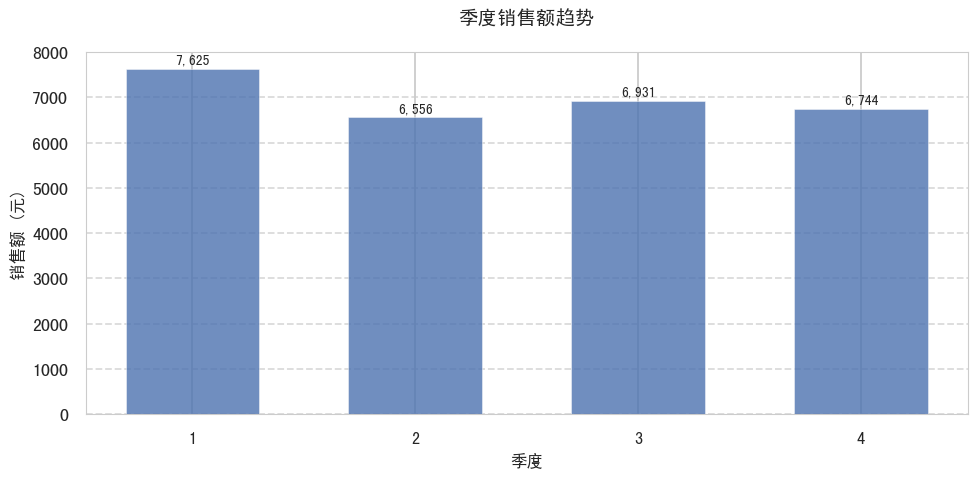

In [65]:
import numpy as np

plt.figure(figsize=(10, 5))

# 生成x轴位置（从1开始）
x_positions = np.arange(1, len(data_quarter) + 1)  # 示例数据假设有4个季度：[1,2,3,4]

# 绘制柱状图（调整x轴起始位置）
bars = plt.bar(
    x_positions,  # ← 关键修改：使用1-based的坐标
    data_quarter['total_amount'],
    color='#4c72b0',
    alpha=0.8,
    width=0.6
)

# 设置x轴刻度和标签
plt.xticks(
    x_positions,  # 刻度位置与柱子中心对齐
    labels=data_quarter['quarter'],  # 使用实际季度标签如 ['Q1','Q2','Q3','Q4'
    fontsize=12
)

# 美化设置
plt.title('季度销售额趋势', fontsize=14, pad=20)
plt.xlabel('季度', fontsize=12)
plt.ylabel('销售额 (元)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 自动计算标签偏移量（动态适配数据范围）
max_amount = data_quarter['total_amount'].max()
label_offset = max_amount * 0.01  # 偏移量为最大高度的5%

# 添加数据标签（精准定位到柱顶中央）
for bar, amount in zip(bars, data_quarter['total_amount']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,  # x坐标：柱中心
        height + label_offset,             # y坐标：柱顶+偏移量
        f'{amount:,.0f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.savefig("images/quarterly_sales.png")  # 新增保存代码
plt.show()

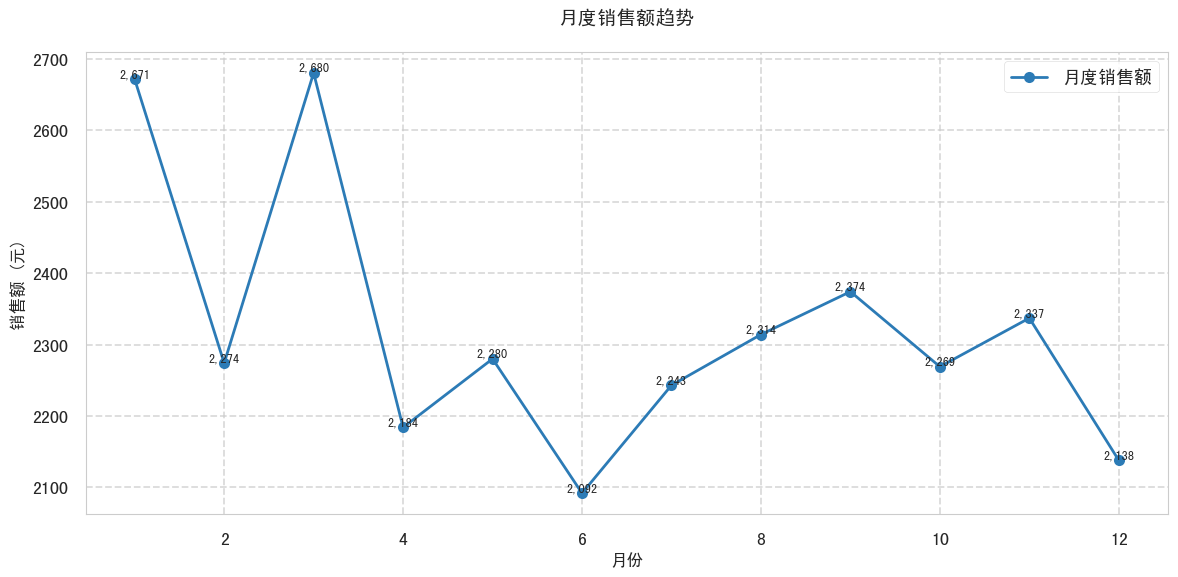

In [66]:
import matplotlib.dates as mdates
# 可视化
plt.figure(figsize=(12, 6))

# 绘制折线
plt.plot(
    data_month['month'],
    data_month['total_amount'],
    marker='o',
    linestyle='-',
    color='#2c7bb6',
    linewidth=2,
    markersize=8,
    label='月度销售额'
)

# 美化设置
plt.title('月度销售额趋势', fontsize=14, pad=20)
plt.xlabel('月份', fontsize=12)
plt.ylabel('销售额 (元)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


# 添加数据标签
for x, y in zip(data_month['month'], data_month['total_amount']):
    plt.text(x, y, f'{y:,.0f}', ha='center', va='bottom', fontsize=9)

plt.legend()
plt.tight_layout()
plt.savefig("images/monthly_sales.png")    # 新增保存代码
plt.show()

/tmp/ipykernel_832953/41729887.py:61: UserWarning: Glyph 165 (\N{YEN SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
/tmp/ipykernel_832953/41729887.py:62: UserWarning: Glyph 165 (\N{YEN SIGN}) missing from font(s) SimHei.
  plt.savefig("images/weekly_sales_pie.png") # 新增保存代码
/home/wangyuhui/.conda/envs/etl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 165 (\N{YEN SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


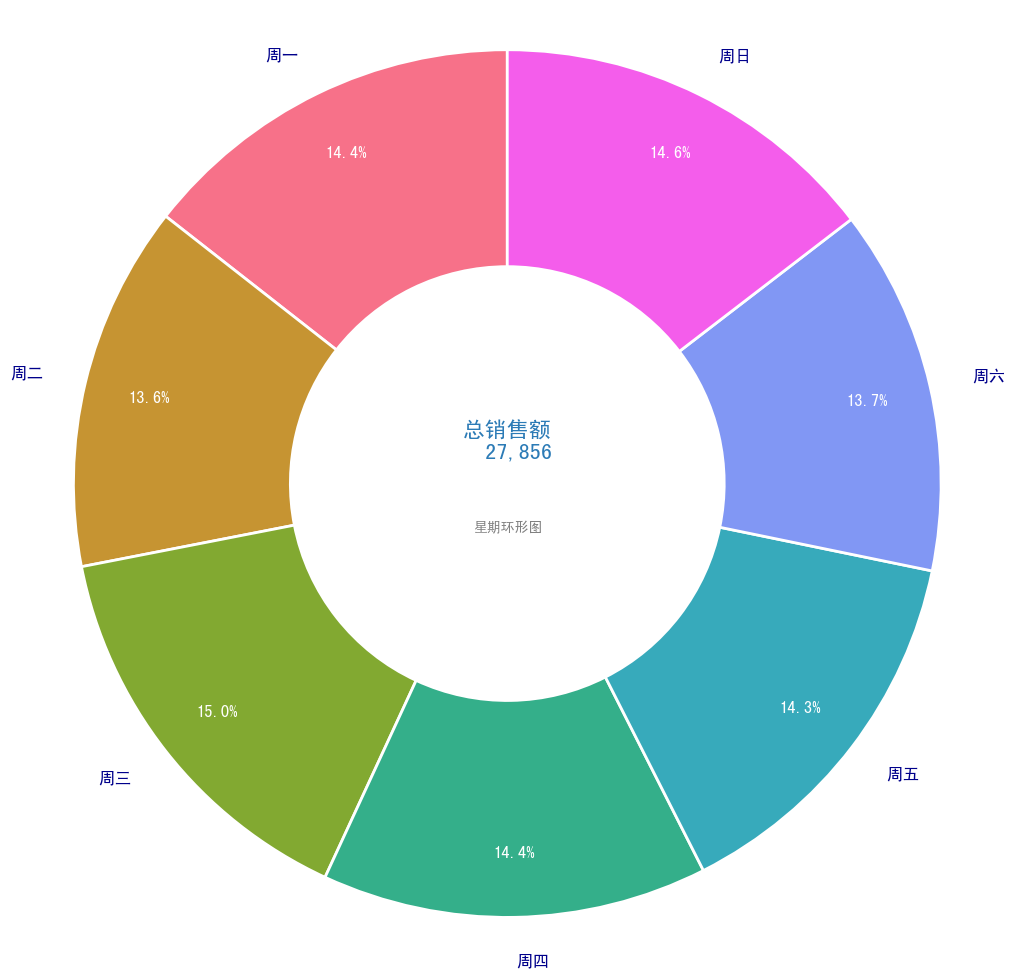

In [67]:
# 1. 定义星期映射关系（0=周日, 1=周一,...,6=周六）
weekday_map = {
    0: '周日',
    1: '周一',
    2: '周二',
    3: '周三',
    4: '周四',
    5: '周五',
    6: '周六'
}

# 2. 转换数值为中文标签，并确保顺序正确（周一至周日）
# 创建完整星期框架（处理可能缺失的天数）
full_week = pd.DataFrame({'weekday': range(7)})
data_weekday = full_week.merge(data_weekday, on='weekday', how='left').fillna(0)

# 3. 按周一(1)到周日(0)重新排序
data_weekday['weekday'] = data_weekday['weekday'].map(weekday_map)
data_weekday = data_weekday.set_index('weekday').reindex(['周一','周二','周三','周四','周五','周六','周日']).reset_index()

# 4. 准备绘图数据
labels = data_weekday['weekday']
sizes = data_weekday['total_amount']  # 或使用 order_count 指标

# -------------------- 可视化 --------------------
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

# 绘制环形图（优化参数）
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',  # 忽略0%标签
    startangle=90,
    colors=sns.color_palette("husl", len(labels)),  # 更鲜艳的色系
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
    textprops={'fontsize': 12, 'color': 'darkblue'},
    pctdistance=0.85  # 将百分比标签移到外沿
)

# 中心空白区域
centre_circle = plt.Circle((0,0), 0.5, color='white')
ax.add_artist(centre_circle)

# 中心标题（动态显示总数）
total = sizes.sum()
plt.text(0, 0.1, f'总销售额\n¥{total:,.0f}', 
         ha='center', va='center', 
         fontsize=16, fontweight='bold',
         color='#2c7bb6')

plt.text(0, -0.1, '星期环形图', 
         ha='center', va='center',
         fontsize=10, color='gray')

# 优化标签位置（防止重叠）
plt.setp(autotexts, size=12, weight='bold', color='white')
plt.setp(texts, size=12)

plt.axis('equal')
plt.tight_layout()
plt.savefig("images/weekly_sales_pie.png") # 新增保存代码
plt.show()

In [68]:
# 识别特定商品类别在不同时间段的购买频率变化
data_category_month = con.execute(f"""
-- 按月份分析特定商品类别的购买频率
SELECT 
  EXTRACT(MONTH FROM purchase_date) AS month,
  category_name,
  SUM(item_count) AS total_amount  -- 购买件数指标
FROM analysis_count_table
GROUP BY month, category_name
ORDER BY month, category_name
""").fetchdf()
print("Parsed item data:")
print(data_category_month.head())

Parsed item data:
   month category_name  total_amount
0      1            办公         123.0
1      1            家居         260.0
2      1            服装         576.0
3      1            母婴         122.0
4      1          汽车用品         125.0


/home/wangyuhui/.conda/envs/etl/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc


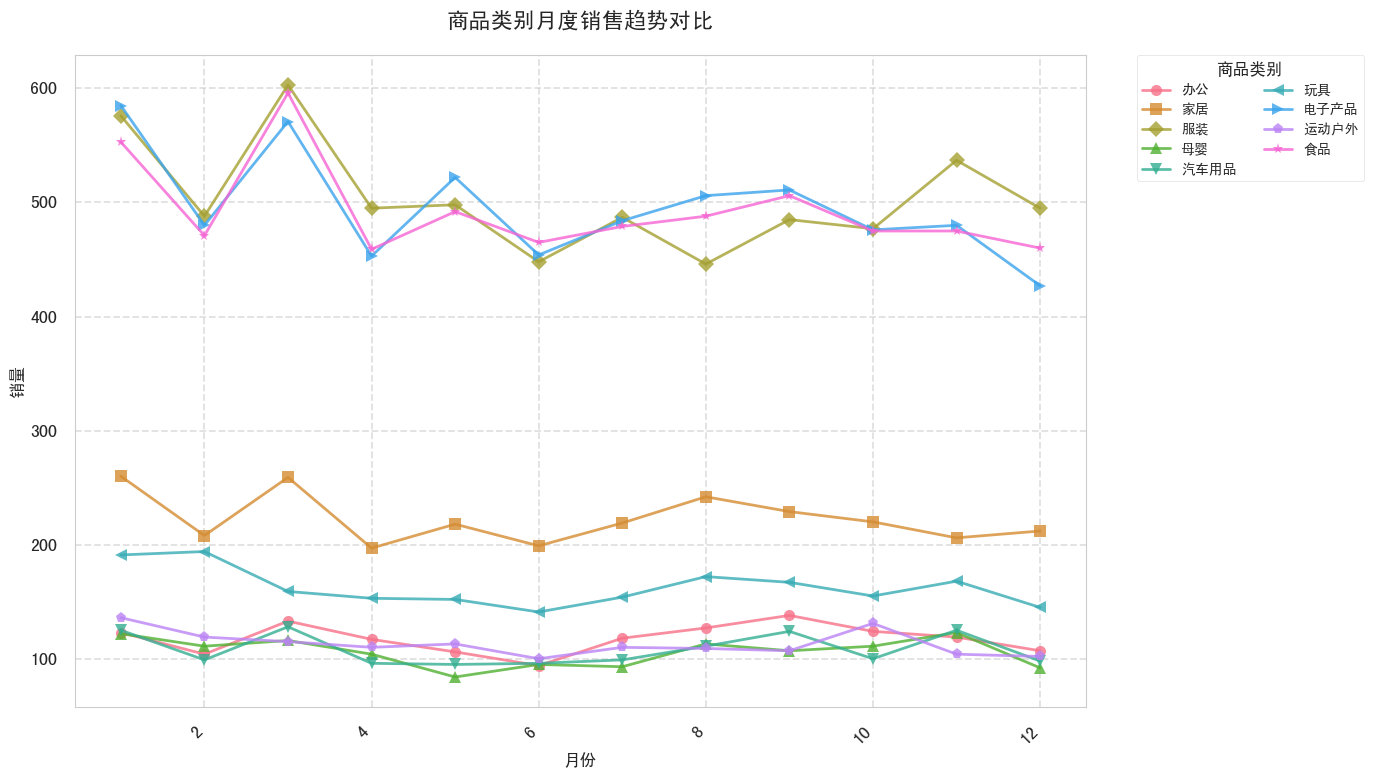

In [69]:
import matplotlib.font_manager as fm

# 数据透视：将类别转为列
pivot_df = data_category_month.pivot_table(
    index='month',
    columns='category_name',
    values='total_amount',
    fill_value=0  # 填充缺失值为0
).reset_index()

# 获取所有类别列表
categories = pivot_df.columns[1:].tolist()

# 设置绘图样式
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", n_colors=len(categories))  # 生成颜色列表
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']  # 标记形状列表

# 设置可视化风格
plt.style.use('seaborn-v0_8-talk')
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
print(matplotlib.matplotlib_fname())

# 绘制每个类别的趋势线
for idx, category in enumerate(categories):
    plt.plot(
        pivot_df['month'],
        pivot_df[category],
        label=category,
        color=palette[idx],
        marker=markers[idx % len(markers)],  # 循环使用标记形状
        linestyle='-',
        linewidth=2,
        markersize=8,
        alpha=0.8
    )

# 优化图表元素
plt.title('商品类别月度销售趋势对比', fontsize=16, pad=20)
plt.xlabel('月份', fontsize=12)
plt.ylabel('销量', fontsize=12)
plt.xticks(rotation=45, ha='right')  # 倾斜日期标签

# 智能显示图例：若类别过多分两列显示
ncol = 2 if len(categories) > 6 else 1
plt.legend(
    title='商品类别',
    bbox_to_anchor=(1.05, 1),  # 图例放在右侧外部
    loc='upper left',
    borderaxespad=0.,
    ncol=ncol,
    fontsize=10,
    title_fontsize=12
)

# 添加辅助元素
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 显示图表
plt.savefig("images/data_category_month.png")  # 新增保存代码
plt.show()

In [70]:
# 探索"先购买A类别，后购买B类别"的时序模式
# SQL 查询：获取用户购买历史（按时间排序）
user_sequences = con.execute(f"""
SELECT 
    order_id,
    ARRAY_AGG(category_name ORDER BY purchase_date) AS sequence  -- 按时间排序的购买序列
FROM (
    SELECT 
        order_id,
        purchase_date,
        category_name
    FROM analysis_table
    WHERE category_name IS NOT NULL
    GROUP BY order_id, purchase_date, category_name  -- 去重同用户同时间的多品类
)
GROUP BY order_id
HAVING COUNT(*) >= 2  -- 过滤单次购买用户
""").fetchdf()

# 解析用户购买序列
print(user_sequences.head(3))

   order_id            sequence
0        92  [服装, 电子产品, 办公, 家居]
1       387      [服装, 电子产品, 家居]
2       560      [电子产品, 服装, 食品]


In [71]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# 生成相邻购买对
transactions_seq = []
for seq in user_sequences['sequence']:
    for i in range(len(seq)-1):
        antecedent = seq[i]
        consequent = seq[i+1]
        transactions_seq.append([f"{antecedent}→{consequent}"])  # 编码顺序对

print("生成的事务数据示例:")
print(transactions_seq[:5])

# 编码为布尔矩阵
encoder = TransactionEncoder()
encoded_data = encoder.fit_transform(transactions_seq)
df = pd.DataFrame(encoded_data, columns=encoder.columns_)

# 挖掘频繁项集（最小支持度1%）
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: list(x)[0])  # 提取单项集

# 重命名列
frequent_itemsets.rename(
    columns={'itemsets': 'sequence_pair', 'support': 'pair_support'},
    inplace=True
)

print("频繁顺序对示例:")
print(frequent_itemsets.head())

# 保存频繁集
frequent_itemsets.to_csv("/home/wangyuhui/dm_wyh2/csv/task3_frequent_itemsets.csv", index=False)


生成的事务数据示例:
[['服装→电子产品'], ['电子产品→办公'], ['办公→家居'], ['服装→电子产品'], ['电子产品→家居']]
频繁顺序对示例:
   pair_support sequence_pair
0      0.014543         办公→服装
1      0.011273       办公→电子产品
2      0.016144         办公→食品
3      0.017744         家居→服装
4      0.020040       家居→电子产品


### 2.4 退款模式分析

- 挖掘与"已退款"或"部分退款"状态相关的商品类别组合
- 分析导致退款的可能商品组合模式
- 找出支持度 ≥ 0.005、置信度 ≥ 0.4的规则

In [72]:
# 分析数据事务表退款
data_status = con.execute(f"""
SELECT 
    order_id,
    ARRAY_AGG(category_name) AS categories,  -- 保留重复类别（默认不去重）
    MAX(payment_status) AS payment_status -- 支付状态
FROM analysis_table
WHERE payment_status IN ('"已退款"', '"部分退款"')
GROUP BY order_id;
""").fetchdf()

print("Parsed item data:")
print(data_status.head())

Parsed item data:
   order_id          categories payment_status
0       122    [玩具, 食品, 服装, 家居]          "已退款"
1       236    [办公, 服装, 母婴, 办公]          "已退款"
2       312        [服装, 家居, 服装]          "已退款"
3       418  [电子产品, 服装, 玩具, 服装]          "已退款"
4       459          [汽车用品, 办公]          "已退款"


In [73]:
# 分析频繁项集
transaction_list_4 = []
for _, row in data_status.iterrows():
    # 提取商品类别列表（假设已正确拆分为列表，如 ['a', 'c']）
    categories = row["categories"].tolist()
    # 清洗支付方式名称（去除双引号）
    payment_status_strip = row["payment_status"].strip('"')
    payment_status = f"STATUS_{payment_status_strip}"
    # 合并商品类别与支付方式为单个事务（如 ['a', 'c', 'b']）
    transaction = categories + [payment_status]
    transaction_list_4.append(transaction)


# 编码并挖掘规则（支持度 ≥ 0.005，置信度 ≥ 0.4）
te = TransactionEncoder()
te_ary = te.fit_transform(transaction_list_4)
df_trans_4 = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets_apriori_4 = apriori(
    df_trans_4,
    min_support=0.005, 
    use_colnames=True
)

# 挖掘频繁项集
frequent_itemsets_fpgrowth_4 = fpgrowth(
    df_trans_4, 
    min_support=0.005,  # 支持度阈值
    use_colnames=True   # 使用类别名称而非列索引
)

print("频繁项集（Apriori）:\n", frequent_itemsets_apriori_4)
print("频繁项集（FP-Growth）:\n", frequent_itemsets_fpgrowth_4)

频繁项集（Apriori）:
       support                           itemsets
0    0.498676                       (STATUS_已退款)
1    0.501324                      (STATUS_部分退款)
2    0.167802                               (办公)
3    0.287363                               (家居)
4    0.552592                               (服装)
..        ...                                ...
338  0.010594    (电子产品, 食品, STATUS_部分退款, 家居, 服装)
339  0.005675    (电子产品, 食品, 玩具, STATUS_部分退款, 家居)
340  0.006243    (电子产品, 食品, STATUS_部分退款, 母婴, 服装)
341  0.007378    (电子产品, 食品, 玩具, STATUS_部分退款, 服装)
342  0.007567  (电子产品, 食品, 运动户外, STATUS_部分退款, 服装)

[343 rows x 2 columns]
频繁项集（FP-Growth）:
       support                     itemsets
0    0.557510                         (食品)
1    0.552592                         (服装)
2    0.498676                 (STATUS_已退款)
3    0.287363                         (家居)
4    0.225880                         (玩具)
..        ...                          ...
338  0.273364            (STATUS_部分退款, 食品)
339  0.137

In [74]:
# 挖掘与"已退款"或"部分退款"状态相关的商品类别组合
# 计算关联规则
rules_apriori_4 = association_rules(
    frequent_itemsets_apriori_4, 
    metric="confidence", 
    min_threshold=0.4, # 置信度阈值
)

# 计算关联规则
rules_fpgrowth_4 = association_rules(
    frequent_itemsets_fpgrowth_4, 
    metric="confidence", 
    min_threshold=0.4,  # 置信度阈值
)

print("关联规则（apriori）:\n", rules_apriori_4[["antecedents", "consequents", "support", "confidence", "lift"]])
print("关联规则（FP-Growth）:\n", rules_fpgrowth_4[["antecedents", "consequents", "support", "confidence", "lift"]])


关联规则（apriori）:
                        antecedents    consequents   support  confidence  \
0                             (办公)   (STATUS_已退款)  0.084374    0.502818   
1                             (家居)   (STATUS_已退款)  0.144911    0.504279   
2                     (STATUS_已退款)           (服装)  0.274309    0.550076   
3                             (服装)   (STATUS_已退款)  0.274309    0.496405   
4                             (母婴)   (STATUS_已退款)  0.078509    0.504253   
..                             ...            ...       ...         ...   
480             (电子产品, 玩具, 食品, 服装)  (STATUS_部分退款)  0.007378    0.487500   
481  (电子产品, STATUS_部分退款, 食品, 运动户外)           (服装)  0.007567    0.430108   
482           (电子产品, 服装, 食品, 运动户外)  (STATUS_部分退款)  0.007567    0.547945   
483  (电子产品, STATUS_部分退款, 服装, 运动户外)           (食品)  0.007567    0.470588   
484    (STATUS_部分退款, 食品, 服装, 运动户外)         (电子产品)  0.007567    0.434783   

         lift  
0    1.008307  
1    1.011237  
2    0.995447  
3    0.995447  
4  

In [75]:
# 定义包含退款和部分退款状态的列表
STATUS_LIST = ['STATUS_已退款', 'STATUS_部分退款']

# 优化筛选逻辑：筛选包含退款或部分退款状态的关联规则
status_category_rules_apriori = rules_apriori_4[
    rules_apriori_4['antecedents'].apply(lambda x: len(x) >= 2) &
    rules_apriori_4['consequents'].apply(lambda x: any(item in STATUS_LIST for item in x))
]

status_category_rules_fpgrowth = rules_fpgrowth_4[
    rules_fpgrowth_4['antecedents'].apply(lambda x: len(x) >= 2) &
    rules_fpgrowth_4['consequents'].apply(lambda x: any(item in STATUS_LIST for item in x))
]

# 展示结果
print(status_category_rules_apriori[['antecedents', 'consequents', 'support', 'confidence']])
print(status_category_rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence']])

              antecedents    consequents   support  confidence
48               (办公, 家居)   (STATUS_已退款)  0.021945    0.513274
50               (办公, 服装)   (STATUS_已退款)  0.044079    0.523596
51               (办公, 母婴)   (STATUS_已退款)  0.010216    0.457627
52             (办公, 汽车用品)   (STATUS_已退款)  0.013810    0.528986
53               (办公, 玩具)   (STATUS_已退款)  0.013810    0.453416
..                    ...            ...       ...         ...
474    (电子产品, 食品, 家居, 服装)  (STATUS_部分退款)  0.010594    0.495575
475    (电子产品, 玩具, 食品, 家居)  (STATUS_部分退款)  0.005675    0.576923
478    (电子产品, 母婴, 食品, 服装)  (STATUS_部分退款)  0.006243    0.471429
480    (电子产品, 玩具, 食品, 服装)  (STATUS_部分退款)  0.007378    0.487500
482  (电子产品, 服装, 食品, 运动户外)  (STATUS_部分退款)  0.007567    0.547945

[185 rows x 4 columns]
          antecedents    consequents   support  confidence
15           (食品, 服装)   (STATUS_已退款)  0.138290    0.509053
17         (电子产品, 服装)   (STATUS_已退款)  0.139236    0.502389
21     (电子产品, 食品, 服装)   (STATUS_已退款)  0.061

与退款相关的关联规则：
              antecedents    consequents   support  confidence
48               (办公, 家居)   (STATUS_已退款)  0.021945    0.513274
50               (办公, 服装)   (STATUS_已退款)  0.044079    0.523596
51               (办公, 母婴)   (STATUS_已退款)  0.010216    0.457627
52             (办公, 汽车用品)   (STATUS_已退款)  0.013810    0.528986
53               (办公, 玩具)   (STATUS_已退款)  0.013810    0.453416
..                    ...            ...       ...         ...
474    (电子产品, 食品, 家居, 服装)  (STATUS_部分退款)  0.010594    0.495575
475    (电子产品, 玩具, 食品, 家居)  (STATUS_部分退款)  0.005675    0.576923
478    (电子产品, 母婴, 食品, 服装)  (STATUS_部分退款)  0.006243    0.471429
480    (电子产品, 玩具, 食品, 服装)  (STATUS_部分退款)  0.007378    0.487500
482  (电子产品, 服装, 食品, 运动户外)  (STATUS_部分退款)  0.007567    0.547945

[185 rows x 4 columns]

高频商品组合：
    antecedents    consequents  antecedent support  consequent support  \
76   (电子产品, 服装)   (STATUS_已退款)            0.277147            0.498676   
82     (食品, 服装)   (STATUS_已退款)            0.271661 

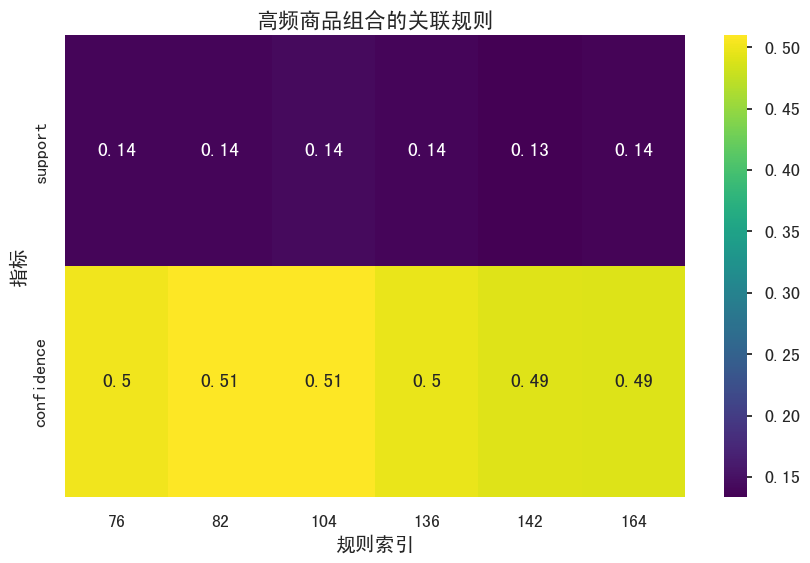

In [76]:
# 分析导致退款的可能商品组合模式
# 显示筛选结果
print("与退款相关的关联规则：")
print(status_category_rules_apriori[['antecedents', 'consequents', 'support', 'confidence']])

# 分析高频商品组合
high_freq_combinations = status_category_rules_apriori[status_category_rules_apriori['support'] > 0.1]
print("\n高频商品组合：")
print(high_freq_combinations)

# 分析低频商品组合
low_freq_combinations = status_category_rules_apriori[status_category_rules_apriori['support'] <= 0.1]
print("\n低频商品组合：")
print(low_freq_combinations)

# 可视化高频商品组合
plt.figure(figsize=(10, 6))
sns.heatmap(high_freq_combinations[['support', 'confidence']].T, annot=True, cmap='viridis')
plt.title('高频商品组合的关联规则')
plt.xlabel('规则索引')
plt.ylabel('指标')
plt.savefig("images/high_freq_refund_heatmap.png")  # 新增保存代码
plt.show()


In [77]:
# 保存任务4的关联规则和频繁项集
status_category_rules_apriori.to_csv("/home/wangyuhui/dm_wyh2/csv/task4_apriori_refund_rules.csv", index=False)
status_category_rules_fpgrowth.to_csv("/home/wangyuhui/dm_wyh2/csv/task4_fpgrowth_refund_rules.csv", index=False)
frequent_itemsets_apriori_4.to_csv("/home/wangyuhui/dm_wyh2/csv/task4_apriori_refund_itemsets.csv", index=False)
frequent_itemsets_fpgrowth_4.to_csv("/home/wangyuhui/dm_wyh2/csv/task4_fpgrowth_refund_itemsets.csv", index=False)

### 3 可视化展示

2. 用户特征的频繁模式可视化（Features）
   
对于用户特征的频繁模式，可以使用条形图来显示最常见的特征组合的支持度。

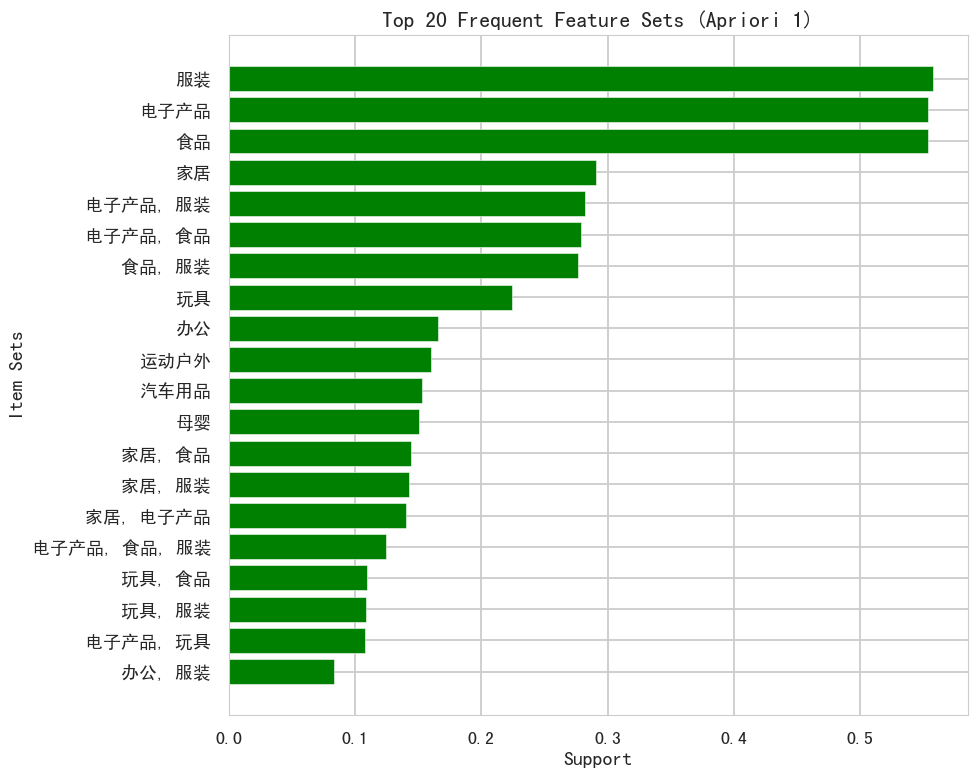

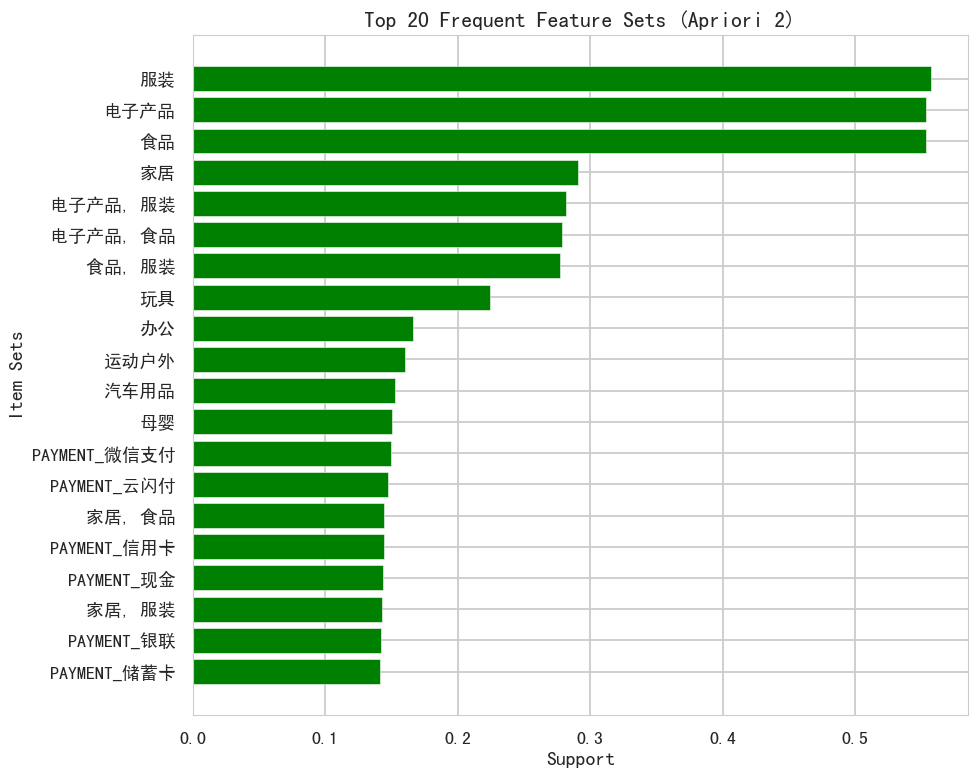

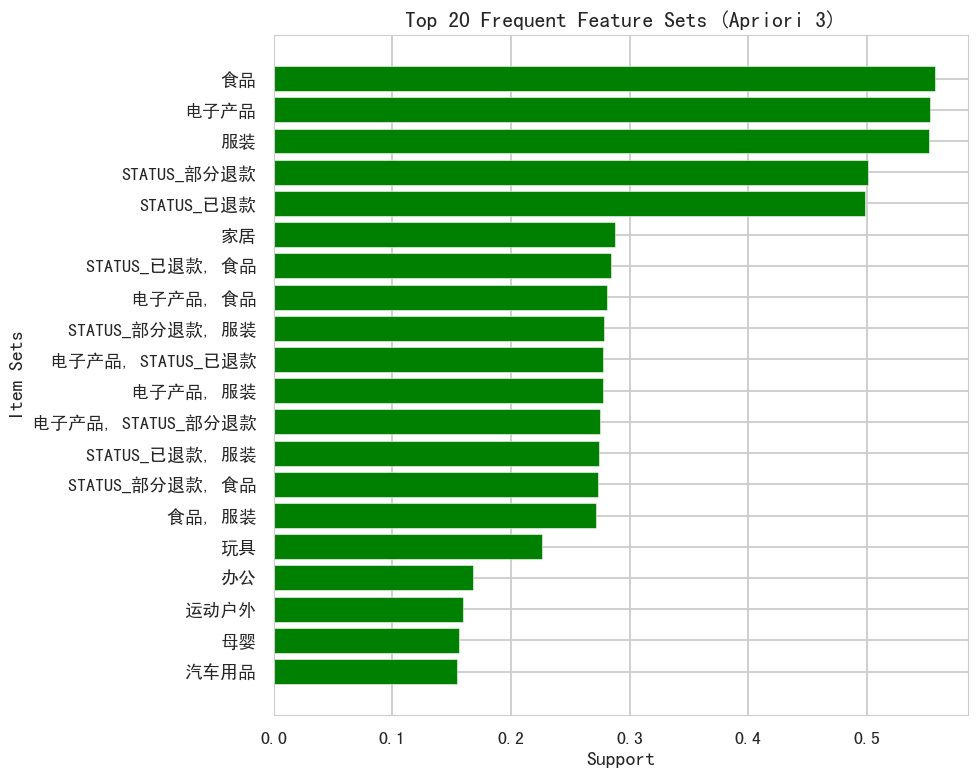

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# frequent_itemsets_apriori, frequent_itemsets_apriori_2, frequent_itemsets_apriori_4 是频繁项集

# 为每个频繁项集创建图表
for i, itemsets in enumerate([frequent_itemsets_apriori, frequent_itemsets_apriori_2, frequent_itemsets_apriori_4], 1):
    # 将 itemsets 转换为字符串表示
    itemsets['itemsets_str'] = itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))
    
    # 按支持度排序
    itemsets_sorted = itemsets.sort_values(by='support', ascending=False)
    
    # 绘图
    plt.figure(figsize=(10, 8))
    plt.barh(itemsets_sorted['itemsets_str'].head(20), itemsets_sorted['support'].head(20), color='green')
    plt.xlabel('Support')
    plt.ylabel('Item Sets')
    plt.title(f'Top 20 Frequent Feature Sets (Apriori {i})')
    plt.gca().invert_yaxis()  # 反转Y轴，使得最大的在上面
    plt.tight_layout()
    plt.savefig(f"images/top_features_apriori_{i}.png")  # 新增保存代码
    plt.show()